In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats

In [6]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
#PREFERED SOLUTION but needs a better vocab 
import phunspell
import spacy
from spacy.tokens import Doc, Token,Span
from spacy.language import Language
pspell = phunspell.Phunspell('pl_PL')
nlp = spacy.load("pl_core_news_sm")
import pl_core_news_sm
nlp = pl_core_news_sm.load()
nlp_clean=spacy.load("pl_core_news_md")
nlp.vocab.strings.add("GAMER")
trained_ner_model = spacy.load("gg_ner")
trained_ner = trained_ner_model.get_pipe("new_ruler")
ner=nlp.get_pipe("ner")
Token.set_extension("is_gamer_entity", default=False, force=True)
# @Language.component("set_gamer_entities")
def set_gamer_entities(doc, trained_ner_model):
    first_doc=doc
    doc = trained_ner(doc)

    for token in doc:
        for token_ready in first_doc:
            token_ready._.is_gamer_entity = False
            if token.ent_type_ == "GAMER" and token.text== token_ready.text:
                token_ready._.is_gamer_entity = True

   
        nlp.get_pipe("ner").add_label("GAMER")
    return first_doc
@Language.factory("gg_ner", default_config={"trained_ner_model": trained_ner_model},)
def custom_ner_factory(nlp, name, trained_ner_model):
    def custom_ner(doc):
        return set_gamer_entities(doc, trained_ner_model)

    return custom_ner
# def custom_ner_component(doc):
#     trained_ner_model = spacy.load("gg_ner")
#     trained_doc = trained_ner_model(doc.text)
#     merged_doc = merge_entities(trained_doc, doc)
#     return merged_doc
# def custom_ner_factory(trained_ner_model, labels):
#     def custom_ner(doc):
#         return custom_ner_component(doc, trained_ner_model, labels)
#     return custom_ner


def check_word_context(word, context):
    word_doc = nlp_clean(word)
    context_doc = nlp_clean(context)

    if not word_doc or not word_doc[0].has_vector:
        print("The word does not have a vector representation.")
        return 0.0  # Return a default value when the word doesn't have a vector representation

    similarity_scores = [word_doc[0].similarity(token) for token in context_doc if token.has_vector]
    avg_similarity = sum(similarity_scores) / len(similarity_scores)

    return avg_similarity

@Language.component('pl_double_check')
def pl_double_check(doc):
    print("im here")
    ents = []


    ents = []

    # Add the custom NER model's entities to the main model's entities
    trained_doc = trained_ner_model(doc)
    # for ent in doc.ents:
        # if ent.label_ == "GAMER":
        #     ents.append(Span(doc, ent.start, ent.end, label="GAMER"))

    for ent in doc.ents:
        if ent.label_ != "":
            ents.append(ent)

    # doc.ents = ents
    ner = nlp.get_pipe("ner")
    ner(doc)
    translation_table = str.maketrans("ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz")

   
    l=[]
   
    for old_token in doc:
         
        
        old_token_text =old_token.text.translate(translation_table)
        # and old_token.ent_type_==None
        if(old_token_text!='' and old_token_text!='.'and old_token_text!=',' and old_token_text!= '?' and old_token_text!='"' and not old_token._.is_gamer_entity):
            if  old_token._.has("corrected"):
                print(f"{old_token_text}_corrected1")
                l.append(old_token_text)
            elif(pspell.lookup(old_token_text)):
                print(f"{old_token_text}_corrected2")
               

                if(old_token.pos_=='NOUN' and (old_token_text[-2:]=='ac' or old_token_text[-2:]=='ec') ):
                    verbified=nlp_clean(old_token_text[0:-1]+'m')[0]
                    print(f"{verbified}_{verbified.pos_}_verbified")
                    if verbified.pos_=='VERB':
                        l.append(old_token_text[0:-1]+'ć')
                    else:
                        l.append(old_token_text)
                else:
                    l.append(old_token_text)
                

            else:
                print(f"{old_token.text}_corrected3")
                new_token=Span(doc, old_token.i, old_token.i+1)
                
                corrected=""

                for index,suggestion in enumerate(pspell.suggest(old_token_text)):

                    if index==0:
                        # if check_word_context(suggestion, doc.text) > 0.5:
                            old_token_text=suggestion

                            print(f"{old_token_text}_suggested")
                        # else :
                        #     l.append(old_token_text)
                       
                 
                print(f"{old_token_text}_pass_this")
                l.append(old_token_text)
        else:
            if(old_token_text=='.' or old_token._.is_gamer_entity or old_token_text==',' and old_token_text== '?'and old_token_text=='"'):
                    l.append(old_token_text)

            
   
    spaces=[]
    for word in l:
        spaces.append(True)
    doc = Doc(nlp.vocab, words=l, spaces=spaces)
    print(f"{doc.text}_doc")
    return (doc)
def SpellContextCheck(df):
   
    for item in [f'nlp_{i}' for i in range(2, 6)]:
       
         text_data = df[item].apply(lambda x:nlp(x))
         df[item]=text_data
     
         print(f"{text_data}_recieved")
    return df


nlp.add_pipe("pl_double_check", after='ner')
nlp.add_pipe("gg_ner", before="pl_double_check")


DATASET_CHECK='NLP_CONNECTED.xlsx'
df = pd.read_excel(io=DATASET_CHECK)

df= SpellContextCheck(df)
# Read(df)
df.to_excel('NLP_CONNECTED.xlsx', index=False)



im here
się_corrected2
wyluzowac_corrected3
wyluzowac_pass_this
się_corrected2
uspokoic_corrected3
uspokoic_pass_this
lubię_corrected2
grac_corrected2
gram_VERB_verbified
satysfakcja_corrected2
przyjemność_corrected2
ochota_corrected2
rozprężenie_corrected2
relaks_corrected2
ukojenie_corrected2
zabawa_corrected2
się wyluzowac wyluzowac . się uspokoic uspokoic . lubię grać . satysfakcja . przyjemność . ochota . rozprężenie . relaks . ukojenie . zabawa . _doc
im here
relaks_corrected2
zabicie_corrected2
nudy_corrected2
rozrywka_corrected2
oderwanie_corrected2
rozproszenie_corrected2
relaks . zabicie nudy . rozrywka . oderwanie . rozproszenie . _doc
im here
relaks_corrected2
rozrywka_corrected2
strata_corrected2
czasu_corrected2
rywalizacja_corrected2
stres_corrected2
relaks . rozrywka . strata czasu . rywalizacja . stres . _doc
im here
odstresować_corrected2
spędzić_corrected2
czas_corrected2
można_corrected2
zabić_corrected2
nudę_corrected2
zabiera_corrected2
czas_corrected2
trochę_corr

In [ ]:
def cmp(word1, word2):
    if word1.lower() != word2.lower():
        return True
    return False

def compare(df_clean, df_corrected):
    with open("results.txt", "w", encoding="utf-8") as f:
        for item in [f'nlp_{i}' for i in range(2, 6)]:
            for index,(word1, word2) in enumerate(zip(df_clean[item], df_corrected[item])):
                if cmp(str(word1), str(word2)):
                    f.write(f"[ [{index+1}] {word1} => {word2}]\n")
    return True

DATASET_CLEAN = 'NLP_CLEAN.xlsx'
DATASET_CHECK = 'NLP_CONNECTED.xlsx'
df_clean = pd.read_excel(io=DATASET_CLEAN)
df_checked = pd.read_excel(io=DATASET_CHECK)
compare(df_clean, df_checked)
nlp_clean("Pozw.")

In [3]:
X_string = 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5'
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [4]:
def del_short_responses(df):
    print(len(df))

    for item in [f'nlp_{i}' for i in range(2, 6)]:
        df = df[df[item].apply(lambda x: len(x) > 10)]
        print(len(df))

    return df

In [9]:

df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df[df['label'] != 1]
df = del_short_responses(df)

469
468
460
449
433


In [10]:
df_pilot = pd.read_excel('NLP_PILOT.xlsx')
df_pilot = del_short_responses(df_pilot)

FileNotFoundError: [Errno 2] No such file or directory: 'NLP_PILOT.XLSX'

In [7]:
from typing import Callable, List, Optional, Tuple
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output
import pandas as pd

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        # self.embedding_func = lambda x: torch.flatten(x[0])
        self.embedding_func = lambda x: torch.mean(x[0], dim=1).squeeze()
        # self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])

In [8]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [9]:
def transform_and_stack(df, arguments=X_string, transformer=bert_transformer):
    tokenized_X_list = []

    for item in arguments:

        item_processed = transformer.transform(list(df[item]))
        tokenized_X_list.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    tokized_X_tuple = tuple(tokenized_X_list)

    X = np.hstack(tokized_X_tuple)
    y = df[Y_string].values
    return X, y

In [10]:
X_main, y_main = transform_and_stack(df)

nlp_5 added to list


In [11]:
X_pilot, y_pilot = transform_and_stack(df_pilot)

nlp_5 added to list


SVR SECTION

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kfold = KFold(n_splits=10, shuffle=True, random_state=8)

In [13]:
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge

SVR_function = svm.SVR(kernel='linear', C=0.0255, tol=1e-3)
# SVR_function = svm.LinearSVR(random_state=0, tol=1e-3, max_iter=2000, C=0.0255)
# SVR_function = LinearRegression()
# SVR_function = Ridge(alpha=200)

y_main_true = []
SVR_predictions = []


for train_index, test_index in kfold.split(X_main):

    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]

    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    SVR_prediction = vector_regression.predict(X_test)
    SVR_predictions = np.concatenate((SVR_predictions, SVR_prediction))

    y_main_true = np.concatenate((y_main_true, y_test))

stats.pearsonr(SVR_predictions, y_main_true)

PearsonRResult(statistic=0.4872110446730373, pvalue=3.401300133271622e-27)

In [14]:
def present_results(prediction, true_values):
        
    print(f'MAE: {mean_absolute_error(prediction, true_values)}')
    print(stats.pearsonr(prediction, true_values))
    
    prediction = [item if item >= 4 else 4 for item in prediction]
    prediction = [item if item <= 20 else 20 for item in prediction]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values = [x[0] for x in sorted_tuples]
    prediction = [round(int(item)) for item in sorted_results]

    plt.figure(figsize=(10, 7))
    plt.plot(range(len(prediction)), prediction, 'o', color=[1, 0, 0, 0.7], label="Prediction")
    plt.plot(range(len(true_values)), true_values, 'o', color=[0, 1, 0, 0.5], label='Observable data')
    plt.legend(loc='upper left')
    plt.title('Connected predictions vs real data')
    plt.show()

MAE: 2.429082609492499
PearsonRResult(statistic=0.4872110446730373, pvalue=3.401300133271622e-27)


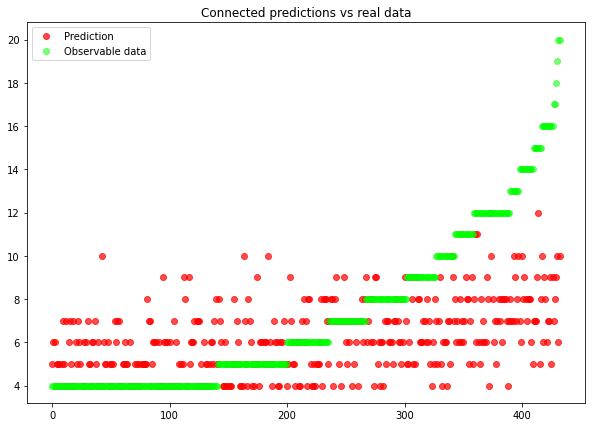

In [15]:
# K FOLD
present_results(SVR_predictions, y_main_true)

MAE: 3.2882121701235643
PearsonRResult(statistic=0.2666998173434987, pvalue=0.010605088031119281)


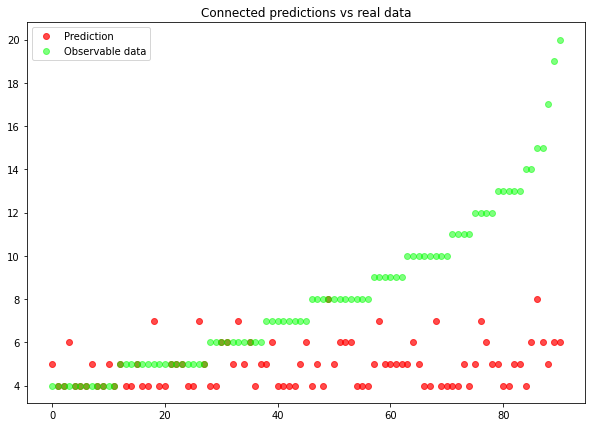

In [16]:
# EVAL DATASET
SVR_pilot_model = SVR_function
SVR_pilot_model.fit(X_main, y_main)
SVR_pilot_predictions = SVR_function.predict(X_pilot)
present_results(SVR_pilot_predictions, y_pilot)

NEURAL NETWORKS SECTION

In [17]:
import tensorflow as tf
import random as python_random

def create_model():
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    keras_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=1)
                        ])

    keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='mean_absolute_error')
    return keras_model

In [18]:
keras_predictions = []

for train_index, test_index in kfold.split(X_main):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    model = create_model()
    model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0)
    keras_prediction = model.predict(X_test).flatten()

    keras_predictions = np.concatenate((keras_predictions, keras_prediction))
    print(stats.pearsonr(keras_prediction, y_test))
    
stats.pearsonr(y_main_true, keras_predictions)

2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.45649519458282123, pvalue=0.0018418264432598461)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.5566368763404254, pvalue=8.714339670524769e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.571243099205797, pvalue=5.128258658018283e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.3004607634973251, pvalue=0.05026602905636091)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.5351179762453737, pvalue=0.00021802022849224016)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.6089248720313127, pvalue=1.471928834788328e-05)
2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.5709950510706364, pvalue=6.374242201890538e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.49521191678296156, pvalue=0.00073492

PearsonRResult(statistic=0.4592104144691441, pvalue=5.6725272561290936e-24)

MAE: 2.4704474246529453
PearsonRResult(statistic=0.4592104144691441, pvalue=5.6725272561290936e-24)


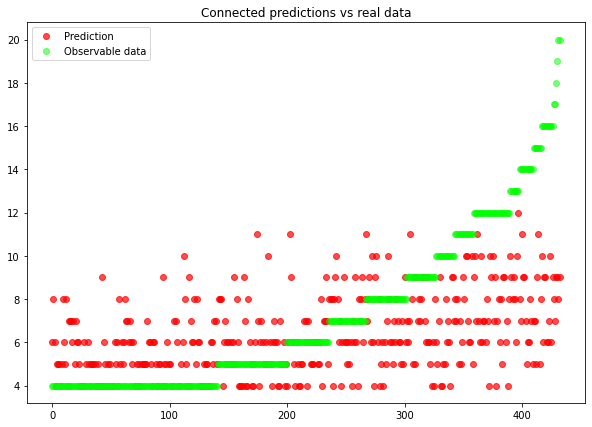

In [19]:
present_results(keras_predictions, y_main_true)

3/3 [==============================] - 0s 0s/step
MAE: 4.012464701474368
PearsonRResult(statistic=0.2869915983827975, pvalue=0.005812866397896812)


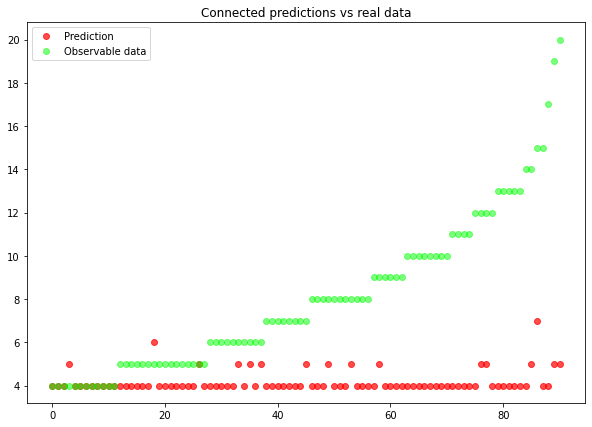

In [20]:
# EVAL DATASET

keras_eval_model = create_model()
keras_eval_model.fit(X_main, y_main, batch_size=64, epochs=200, verbose=0)
keras_pilot_predictions = keras_eval_model.predict(X_pilot).flatten()
present_results(keras_pilot_predictions, y_pilot)


CONNECTING RESULTS

MAE: 2.428875188389137
PearsonRResult(statistic=0.4875903298066905, pvalue=3.0614617422490212e-27)


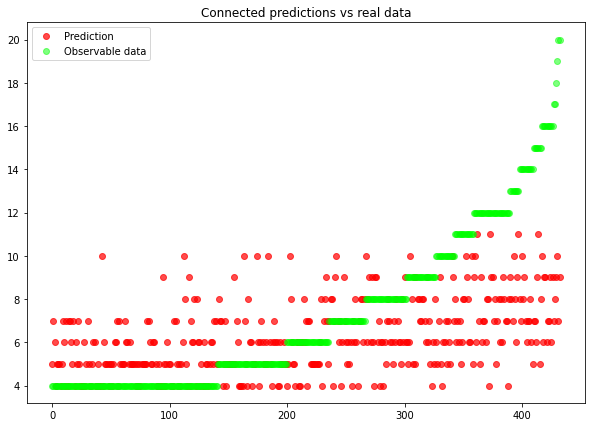

In [21]:
connected_main = [(k + s)/2 for k, s in zip(keras_predictions, SVR_predictions)]
present_results(connected_main, y_main_true)

MAE: 3.6025994323941752
PearsonRResult(statistic=0.28220881439783396, pvalue=0.006724102588255513)


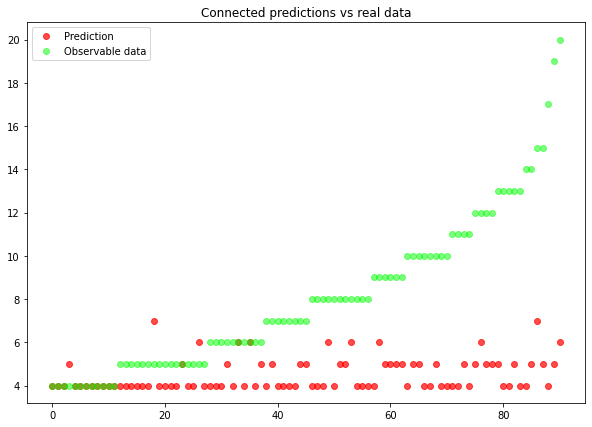

In [22]:
connected_eval = [(k + s)/2 for k, s in zip(keras_pilot_predictions, SVR_pilot_predictions)]
present_results(connected_eval, y_pilot)